In [ ]:
import numpy as np
import pandas as pd
import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Carregamento da base

In [ ]:
def carrega_base(file_path, chunk_size=int(1e6)):
    dataframes = pd.read_csv(
        file_path, sep=';', chunksize=chunk_size, parse_dates=['vacina_dataaplicacao','paciente_datanascimento','data_importacao_rnds']
    )
    l = []

    for chunk_df in dataframes:
        l.append(chunk_df)
        
    dataframe = pd.concat(l, ignore_index=True)
    dataframe['vacina_dataaplicacao'] = pd.to_datetime(dataframe['vacina_dataaplicacao'].dt.date)
    dataframe['paciente_datanascimento'] = pd.to_datetime(dataframe['paciente_datanascimento'].dt.date)
    dataframe['data_importacao_rnds'] = pd.to_datetime(dataframe['data_importacao_rnds'].dt.date)

    return dataframe

In [ ]:
dados = carrega_base('../backups/datasets 2021-06-30/Dados Completos_2021-06-30.csv')

# Aviso



O objetivo desse relatório é alertar aos responsáveis e comunidade em geral dos **possíveis** problemas encontrados na base de dados de vacinação de COVID-19  que podem levar a importantes erros de avaliação do estágio atual da campanha de vacinação. Como não temos conhecimento nem acesso à base de dados original, nem como se deu o processo de anonimização, coleta dos dados e envio da informação através dos sistemas do SUS, não podemos afirmar categoricamente a existência de alguns dos problemas, muito menos apontar as causas ou  responsáveis por eventuais falhas.  Tal trabalho foi realizado pela equipe do **Laboratório de Estatística e Ciência dos Dados da UFAL (LED/UFAL)**  dentro do projeto **MODCOVID-19**. Mais informações em https://im.ufal.br/laboratorio/led/ e http://www.cemeai.icmc.usp.br/ModCovid19/. 


# Sobre os dados

A base de dados da campanha nacional de imunização é uma base de dados pessoais anonimizada, de acesso público, e que pode ser obtida no site https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao. Essa base contém dados de vacinados no Plano Nacional de Vacinação da COVID-19 e é atualizada diariamente. No site podem ser obtidos  28 arquivos, sendo um para cada unidade da federação, e um arquivo consolidado de  todo o país. Em geral, os arquivos são relativamente grandes (>200MB) e  exigem habilidades computacionais além do uso básico de Excel para o tratamento das informações. A tabela com todos os dados de vacinação do Brasil possuia em 08/06/2021  67.585.268 de registros e um total de cerca de 34G de dados no formato `.csv`. Cada linha da tabela corresponde à um episódio de vacinação e as colunas da tabela são informações relativas à esse episódio, podendo informar dados relativos ao paciente, ao local de vacinação, à vacina utilizada ou ao processo de informação dos dados ao sistema do SUS pelo sistema municipal, caso haja.   As colunas da tabela e os tipos de dados são: 

In [ ]:
dados.dtypes

# Quantidade de registros

In [ ]:
length = dados.shape[0]
last_date = datetime.datetime.strftime(dados['data_importacao_rnds'].max(), '%d/%m/%Y')
print(f'Quantidade de registros: {length}\nÚltimo registro em {last_date}')

# Análise inicial dos dados

O site opendatasus apresenta um dicionário de dados, onde o significado de cada informação relativa a um registro na tabela é esclarecido:

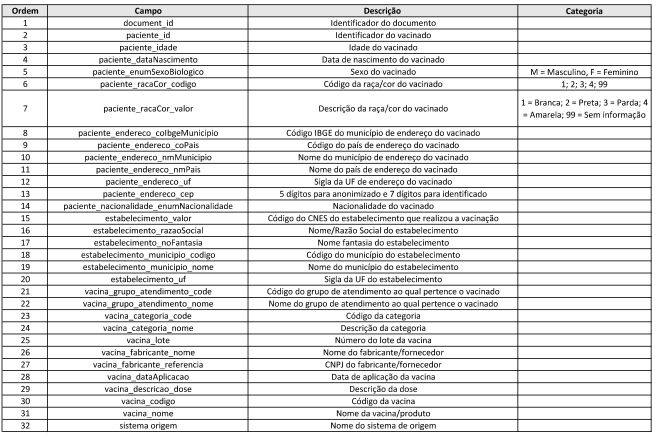


 https://opendatasus.saude.gov.br/dataset/b772ee55-07cd-44d8-958f-b12edd004e0b/resource/38ead83d-b115-4219-852e-7244792bc311/download/dicionario-de-dados-vacinacao.pdf

O dicionário de dados deixa espaço à muitas questões. Por exemplo, apesar da coluna `sistema_origem` informar o sistema de origem dos dados, a informação não é clara (se são importados de sistemas do SUS já existentes, se são inseridos pelo aplicador ou ou um terceiro) e serve provavelmente para controle interno do Ministério da Saúde. A descrição das colunas poderia ser aprimorada, indicando por exemplo, qual o tipo do dado, se o campo `paciente_id` é uma chave-única para o paciente (ver casos na seção "Há pacientes com mesmo `paciente_id`" abaixo), qual código usado para os municípios (IBGE ou Datasus?), qual o papel do `document_id` (que aparenta ser uma chave-única do registro da tabela) etc.

## Dados duplicados

###  Há registros de vacinação  duplicados?

Uma importante inconsistência encontrada refere-se aos registros duplicados quando filtramos a tabela buscando registros **EXATAMENTE IGUAIS EM TODAS AS COLUNAS**. Caso isso não seja tratado previamente, pode gerar diferenças enormes entre o número de vacinados com primeira dose ou segunda dose. Mostramos o total de registros duplicados únicos e 3 exemplos. 


In [ ]:
n = dados[dados.duplicated(keep=False)].shape[0]
print(f'Total de registros duplicados com todos valores iguais: {n}\n')

dados[dados.duplicated(keep=False)].sort_values(by='paciente_id')[:6]

Percentual de dados duplicados (por sistema de origem)

In [ ]:
((dados[dados.duplicated(keep=False)].groupby(by=['sistema_origem']).size()/dados.groupby(by=['sistema_origem']).size())*100).dropna().round(2).apply(lambda x: str(x)+'%').to_frame(name='Percentual de duplicados').sort_values(by=['Percentual de duplicados'])

Percentual de dados duplicados (por unidade federativa e sistema de origem)

In [ ]:
((dados[dados.duplicated(keep=False)].groupby(by=['estabelecimento_uf']).size()/dados.groupby(by=['estabelecimento_uf']).size())*100).dropna().round(2).apply(lambda x: str(x)+'%').to_frame(name='Percentual de duplicados').sort_values(by=['Percentual de duplicados'])

### Há registros de vacinação que foram informados duas vezes pelos sistemas municipais? 

Existem registros com os valores de **TODAS AS COLUNAS IGUAIS EXCETO AS QUE TRATAM DO ENVIO DE INFORMAÇÕES AO SISTEMA DO SUS**. Isso indica fortemente que houve o registro do mesmo episódio de vacinação mais de uma vez nos sistemas do SUS. Filtrando a tabela buscando registros EXATAMENTE IGUAIS EM TODAS AS COLUNAS EXCETO AS QUE TRATAM DO  ENVIO DE INFORMAÇÕES AO SISTEMA DO SUS (`document_id`, `sistema_origem`, `data_importacao_rnds` e `id_sistema_origem`). Mostramos o total de registros duplicados únicos e 3 exemplos. 


In [ ]:
colunas = ['paciente_id', 'paciente_idade',
           'paciente_datanascimento', 'paciente_enumsexobiologico',
           'paciente_racacor_codigo', 'paciente_racacor_valor',
           'paciente_endereco_coibgemunicipio', 'paciente_endereco_copais',
           'paciente_endereco_nmmunicipio', 'paciente_endereco_nmpais',
           'paciente_endereco_uf', 'paciente_endereco_cep',
           'paciente_nacionalidade_enumnacionalidade', 'estabelecimento_valor',
           'estabelecimento_razaosocial', 'estalecimento_nofantasia',
           'estabelecimento_municipio_codigo', 'estabelecimento_municipio_nome',
           'estabelecimento_uf', 'vacina_grupoatendimento_codigo',
           'vacina_grupoatendimento_nome', 'vacina_categoria_codigo',
           'vacina_categoria_nome', 'vacina_lote', 'vacina_fabricante_nome',
           'vacina_fabricante_referencia', 'vacina_dataaplicacao',
           'vacina_descricao_dose', 'vacina_codigo', 'vacina_nome']

n = dados[dados.duplicated(subset=colunas, keep=False)].shape[0]
print(f'Total de registros duplicados com todos valores iguais exceto os relativos ao processo de informação \naos sistemas do SUS: {n}\n')

dados[dados.duplicated(subset=colunas, keep=False)].sort_values(by='paciente_id')[:6]

Percentual de registros de vacinação que foram informados duas vezes ou mais pelos sistemas municipais (por unidade federativa)

In [ ]:
((dados[dados.duplicated(subset=colunas, keep=False)].groupby(by=['estabelecimento_uf']).size()/dados.groupby(by=['estabelecimento_uf']).size())*100).dropna().round(2).apply(lambda x: str(x)+'%').to_frame(name='Percentual de registros duplicados').sort_values(by=['Percentual de registros duplicados'])

## Há pacientes com mesmo `paciente_id` que possuem dados (como data de nascimento ou sexo) diferentes? 

Aparentemente, o identificador `paciente_id` parece **não ser um identificador único**, ou seja, há pessoas diferentes com o mesmo identificador. Encontramos pacientes com mesmo `paciente_id` mas com alguns dados diferentes, como sexo ou data de nascimento. Considerando o fato que o número relativo de casos é muito baixo (menos de mil em 45 milhões), acreditamos que o identificador é único e que houve problemas na hora da importação dos dados desses pacientes específicos a partir das bases do SUS. Hipoteticamente, assumindo que os dados do sistema de informação da vacina são extraidos automaticamente do Cadastro Nacional de Saúde (CadÚnico) do SUS, outra hipótese é que há pacientes com **dois ou mais registros no Cadastro Nacional de Saúde** em que os dados pessoais diferem  (sexo, data de nascimento, por exemplo). Uma última alternativa é que a inserção de alguns dados tenha sido manual, o que achamos altamente improvável, considerando o baixo número relativo de inconsistências dessa natureza. 

In [ ]:
colunas = ['paciente_id', 'paciente_datanascimento',
           'paciente_enumsexobiologico']

n = dados[dados['paciente_id'].isin(dados.drop_duplicates(subset=colunas)['paciente_id'][dados.drop_duplicates(subset=colunas)['paciente_id'].duplicated()].to_list())].shape[0]
print(f'Total de registros com mesmo paciente_id e dados distintos: {n}\n')
      
dados[dados['paciente_id'].isin(dados.drop_duplicates(subset=colunas)['paciente_id'][dados.drop_duplicates(subset=colunas)['paciente_id'].duplicated()].to_list())].sort_values(by='paciente_id')[:6]

Quantidade de pacientes com mesmo paciente_id que possuem dados (como data de nascimento ou sexo) diferentes (por unidade federativa)

In [ ]:
dados[dados['paciente_id'].isin(dados.drop_duplicates(subset=colunas)['paciente_id'][dados.drop_duplicates(subset=colunas)['paciente_id'].duplicated()].to_list())].drop_duplicates(subset=['paciente_id'], keep='first').groupby(by=['estabelecimento_uf']).size().to_frame(name='Quantidade de registros').sort_values(by=['Quantidade de registros'])

## `paciente_id` que aparecem várias vezes

Analisamos o número de aparecimentos de um dado 'paciente_id' ao longo da tabela e contamos o total para cada valor possível do número de aparecimentos



In [ ]:
dados.groupby(by=['paciente_id']).size().to_frame(name='Quantidade de vezes que paciente_id apareceu').reset_index(drop=False).groupby(by=['Quantidade de vezes que paciente_id apareceu']).size().to_frame(name='Total').reset_index(drop=False).style.hide_index()

Quantidade de vezes que o `paciente_id` apareceu (por unidade federativa)

In [ ]:
n = dados.groupby(by=['estabelecimento_uf', 'paciente_id']).size().to_frame(name='Quantidade de vezes que paciente_id apareceu').reset_index(drop=False).groupby(by=['estabelecimento_uf', 'Quantidade de vezes que paciente_id apareceu']).size().to_frame(name='Quantidade de vezes que paciente_id apareceu')
n[list(map(lambda x: x[1]>2, n.index))]

# Dados inconsistentes

## Registros anteriores ao início da vacinação

Encontramos alguns registros com data anterior do início da vacinação que, claramente, não fazem parte dos dados dos estudos de fase III da CoronaVac ou CoviShield no Brasil. 

In [ ]:
n = dados.loc[dados['vacina_dataaplicacao']< np.datetime64('2021-01-17')].shape[0]
print(f'Total de registros com data de vacinação anteriores à 17-01-2021: {n}\n')

dados[dados['vacina_dataaplicacao']<np.datetime64('2021-01-17')].sort_values(by='vacina_dataaplicacao')[:6]

Registros anteriores ao início da vacinação (por vacina)

In [ ]:
dados[dados['vacina_dataaplicacao']<np.datetime64('2021-01-17')].groupby(by=['vacina_nome']).size().to_frame(name='Quantidade de registros')

Registros anteriores ao início da vacinação a cada (por vacina e unidade federativa)

In [ ]:
dados[dados['vacina_dataaplicacao']<np.datetime64('2021-01-17')].groupby(by=['estabelecimento_uf', 'vacina_nome']).size().to_frame(name='Quantidade de registros')

## Pacientes com data de nascimento muito antiga

In [ ]:
n=dados.loc[dados['paciente_datanascimento']<'1900-01-01'].shape[0]
print(f'Pacientes com data de nascimento no Século XIX: {n}\n')

dados.loc[dados['paciente_datanascimento']<'1900-01-01'].sort_values(by='paciente_datanascimento')[:6]

Pacientes com data de nascimento no Século XIX (por unidade faixa etária)

In [ ]:
dados.loc[dados['paciente_datanascimento']<'1900-01-01'].groupby(by=[pd.cut(dados.loc[dados['paciente_datanascimento']<'1900-01-01']['paciente_idade'], np.array([120,125,130,135]))]).size().to_frame(name='Pessoas com data de nascimento muito antiga')

Pacientes com data de nascimento no Século XIX (por unidade federativa e faixa etária)

In [ ]:
n = dados.loc[dados['paciente_datanascimento']<'1900-01-01'].groupby(by=['estabelecimento_uf', pd.cut(dados.loc[dados['paciente_datanascimento']<'1900-01-01']['paciente_idade'], np.array([120,125,130,135, 140, 145, 150]))]).size().to_frame(name='Pessoas com data de nascimento muito antiga')
n[n['Pessoas com data de nascimento muito antiga']>0]

## Registros de estudos de Fase III ocorridos em 2020

Analisamos aplicações no ano de 2020. 

In [ ]:
n = dados.loc[(dados['vacina_dataaplicacao']<np.datetime64('2021-01-01')) & (dados['vacina_dataaplicacao']>np.datetime64('2019-12-31'))].shape[0]
print(f'Total de registros com data de vacinação no ano de 2020: {n}\n')

dados.loc[(dados['vacina_dataaplicacao']<np.datetime64('2021-01-01')) & (dados['vacina_dataaplicacao']>np.datetime64('2019-12-31'))][:6]

Aplicações no ano de 2020 (por vacina):

In [ ]:
dados.loc[(dados['vacina_dataaplicacao']<np.datetime64('2021-01-01')) & (dados['vacina_dataaplicacao']>np.datetime64('2019-12-31'))].groupby(by=['vacina_nome']).size().to_frame(name='Quantidade de aplicações')

Aplicações no ano de 2020 (por unidade federativa, e vacina):

In [ ]:
dados.loc[(dados['vacina_dataaplicacao']<np.datetime64('2021-01-01')) & (dados['vacina_dataaplicacao']>np.datetime64('2019-12-31'))].groupby(by=['estabelecimento_uf', 'vacina_nome']).size().to_frame(name='Quantidade de aplicações')

## Paciente com dose no futuro

Analisamos aplicações com data no futuro. 

In [ ]:
n = dados.loc[(dados['vacina_dataaplicacao']>datetime.datetime.today())].shape[0]
print(f'Total de registros com data de vacinação no futuro: {n}\n')

dados.loc[(dados['vacina_dataaplicacao']>datetime.datetime.today())]

Registros com dose no futuro (por unidade federativa)

In [ ]:
dados.loc[(dados['vacina_dataaplicacao']>datetime.datetime.today())].groupby(by=['estabelecimento_uf']).size().to_frame(name='Quantidade de aplicações')

## Pacientes somente com registro da segunda dose

Listamos o número total e um exemplo de 6 pacientes que só tem registros da segunda dose aplicada. 


In [ ]:
n=set(dados[dados['vacina_descricao_dose']=='\xa0\xa0\xa0\xa02ª\xa0Dose']['paciente_id']).difference(set(dados[dados['vacina_descricao_dose']=='\xa0\xa0\xa0\xa01ª\xa0Dose']['paciente_id']))
print(f'Total de pacientes que só tem o registro da segunda dose: {len(n)}\n')

dados.loc[dados['paciente_id'].isin(n)][:6]

In [ ]:
dados.loc[dados['paciente_id'].isin(n)].drop_duplicates(subset=['paciente_id'], keep='first').groupby(by=['vacina_nome']).size().to_frame(name='Total')

Pacientes somente com registro da segunda dose (por vacina e unidade federativa)

In [ ]:
dados.loc[dados['paciente_id'].isin(n)].drop_duplicates(subset=['paciente_id'], keep='first').groupby(by=['estabelecimento_uf', 'vacina_nome']).size().to_frame(name='Total')

## Segunda dose antes da primeira

Pessoas com data da segunda dose anterior a data da primeira dose.

Obs.: A análise foi feita removendo reptições de ID's e dose, bem como casos com primeira ou segunda dose nula. Exibimos 3 exemplos. 

In [ ]:
n = set(dados.drop_duplicates(subset=['paciente_id', 'vacina_descricao_dose']).pivot(index=['paciente_id', 'vacina_nome'], columns='vacina_descricao_dose', values='vacina_dataaplicacao').reset_index(drop=False)[(dados.drop_duplicates(subset=['paciente_id', 'vacina_descricao_dose']).pivot(index=['paciente_id', 'vacina_nome'], columns='vacina_descricao_dose', values='vacina_dataaplicacao').reset_index(drop=False)['\xa0\xa0\xa0\xa02ª\xa0Dose'] < dados.drop_duplicates(subset=['paciente_id', 'vacina_descricao_dose']).pivot(index=['paciente_id', 'vacina_nome'], columns='vacina_descricao_dose', values='vacina_dataaplicacao').reset_index(drop=False)['\xa0\xa0\xa0\xa01ª\xa0Dose'])]['paciente_id'])
print(f'Número de pessoas com segunda dose antes da primeira: {len(n)}\n')

dados[dados['paciente_id'].isin(n)].sort_values(by=['paciente_id', 'vacina_nome', 'vacina_dataaplicacao'])[:6]

In [ ]:
dados[dados['paciente_id'].isin(n)].drop_duplicates(subset=['paciente_id'], keep='first').groupby(by=['vacina_nome']).size().to_frame(name='Quantidade de 2ª doses antes da 1ª')

Segunda dose antes da primeira (por vacina e unidade federativa)

In [ ]:
dados[dados['paciente_id'].isin(n)].drop_duplicates(subset=['paciente_id'], keep='first').groupby(by=['estabelecimento_uf', 'vacina_nome']).size().to_frame(name='Pessoas com 2ª dose antes da 1ª')